In [2]:
# %%
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import os

In [3]:
# %%
file_pattern = "/Users/bhupendra/projects/crocus/data/flux_data/data/netcdf/resnc/202???/*.nc"
ds = xr.open_mfdataset(file_pattern, combine='by_coords')

time = pd.to_datetime(ds['time'].values, unit='s')

df = pd.DataFrame({
    'time': time,
    'H': ds['H'].values,  
    'LE': ds['LE'].values,  
    'H2O_flux': ds['h2o_flux'].values, 
    'CO2_flux': ds['co2_flux'].values, 
    'Tau': ds['Tau'].values, 
    'wind_speed': ds['wind_speed'].values, 
    'wind_dir': ds['wind_dir'].values,  
    'w_rot': ds['w_rot'].values,
    'qc_H': ds['qc_H'].values,
    'qc_LE': ds['qc_LE'].values,
    'qc_h2o_flux': ds['qc_h2o_flux'].values,
    'qc_co2_flux': ds['qc_co2_flux'].values,
    'qc_Tau': ds['qc_Tau'].values,
})

df['time'] = time.tz_localize('UTC').tz_convert('America/Chicago')

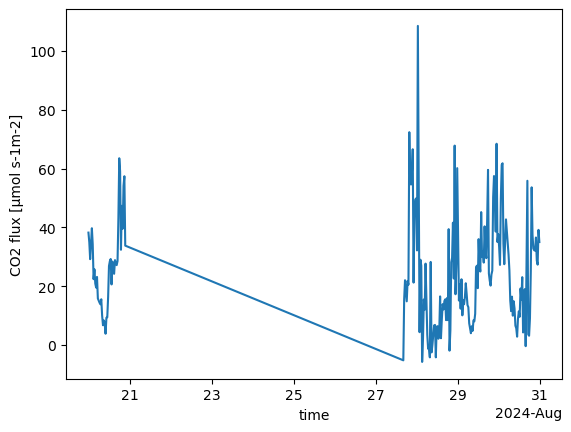

In [4]:
ds.co2_flux.sel(time=slice('2024-08-20', '2024-08-30')).plot()


In [5]:
# Set variable to NaN if QC fails
df.loc[df['qc_H'] > 1, 'H'] = pd.NA
df.loc[df['qc_LE'] > 1, 'LE'] = pd.NA
df.loc[df['qc_h2o_flux'] > 1, 'H2O_flux'] = pd.NA
df.loc[df['qc_co2_flux'] > 1, 'CO2_flux'] = pd.NA
df.loc[df['qc_Tau'] > 1, 'Tau'] = pd.NA

In [6]:
units = {
    'H': ds['H'].units if 'units' in ds['H'].attrs else '',
    'LE': ds['LE'].units if 'units' in ds['LE'].attrs else '',
    'H2O_flux': ds['h2o_flux'].units if 'units' in ds['h2o_flux'].attrs else '',
    'CO2_flux': ds['co2_flux'].units if 'units' in ds['co2_flux'].attrs else '',
    'wind_speed': ds['wind_speed'].units if 'units' in ds['wind_speed'].attrs else 'm/s',
    'wind_dir': ds['wind_dir'].units if 'units' in ds['wind_dir'].attrs else 'degrees',
    'Tau': ds['Tau'].units if 'units' in ds['Tau'].attrs else '',
}

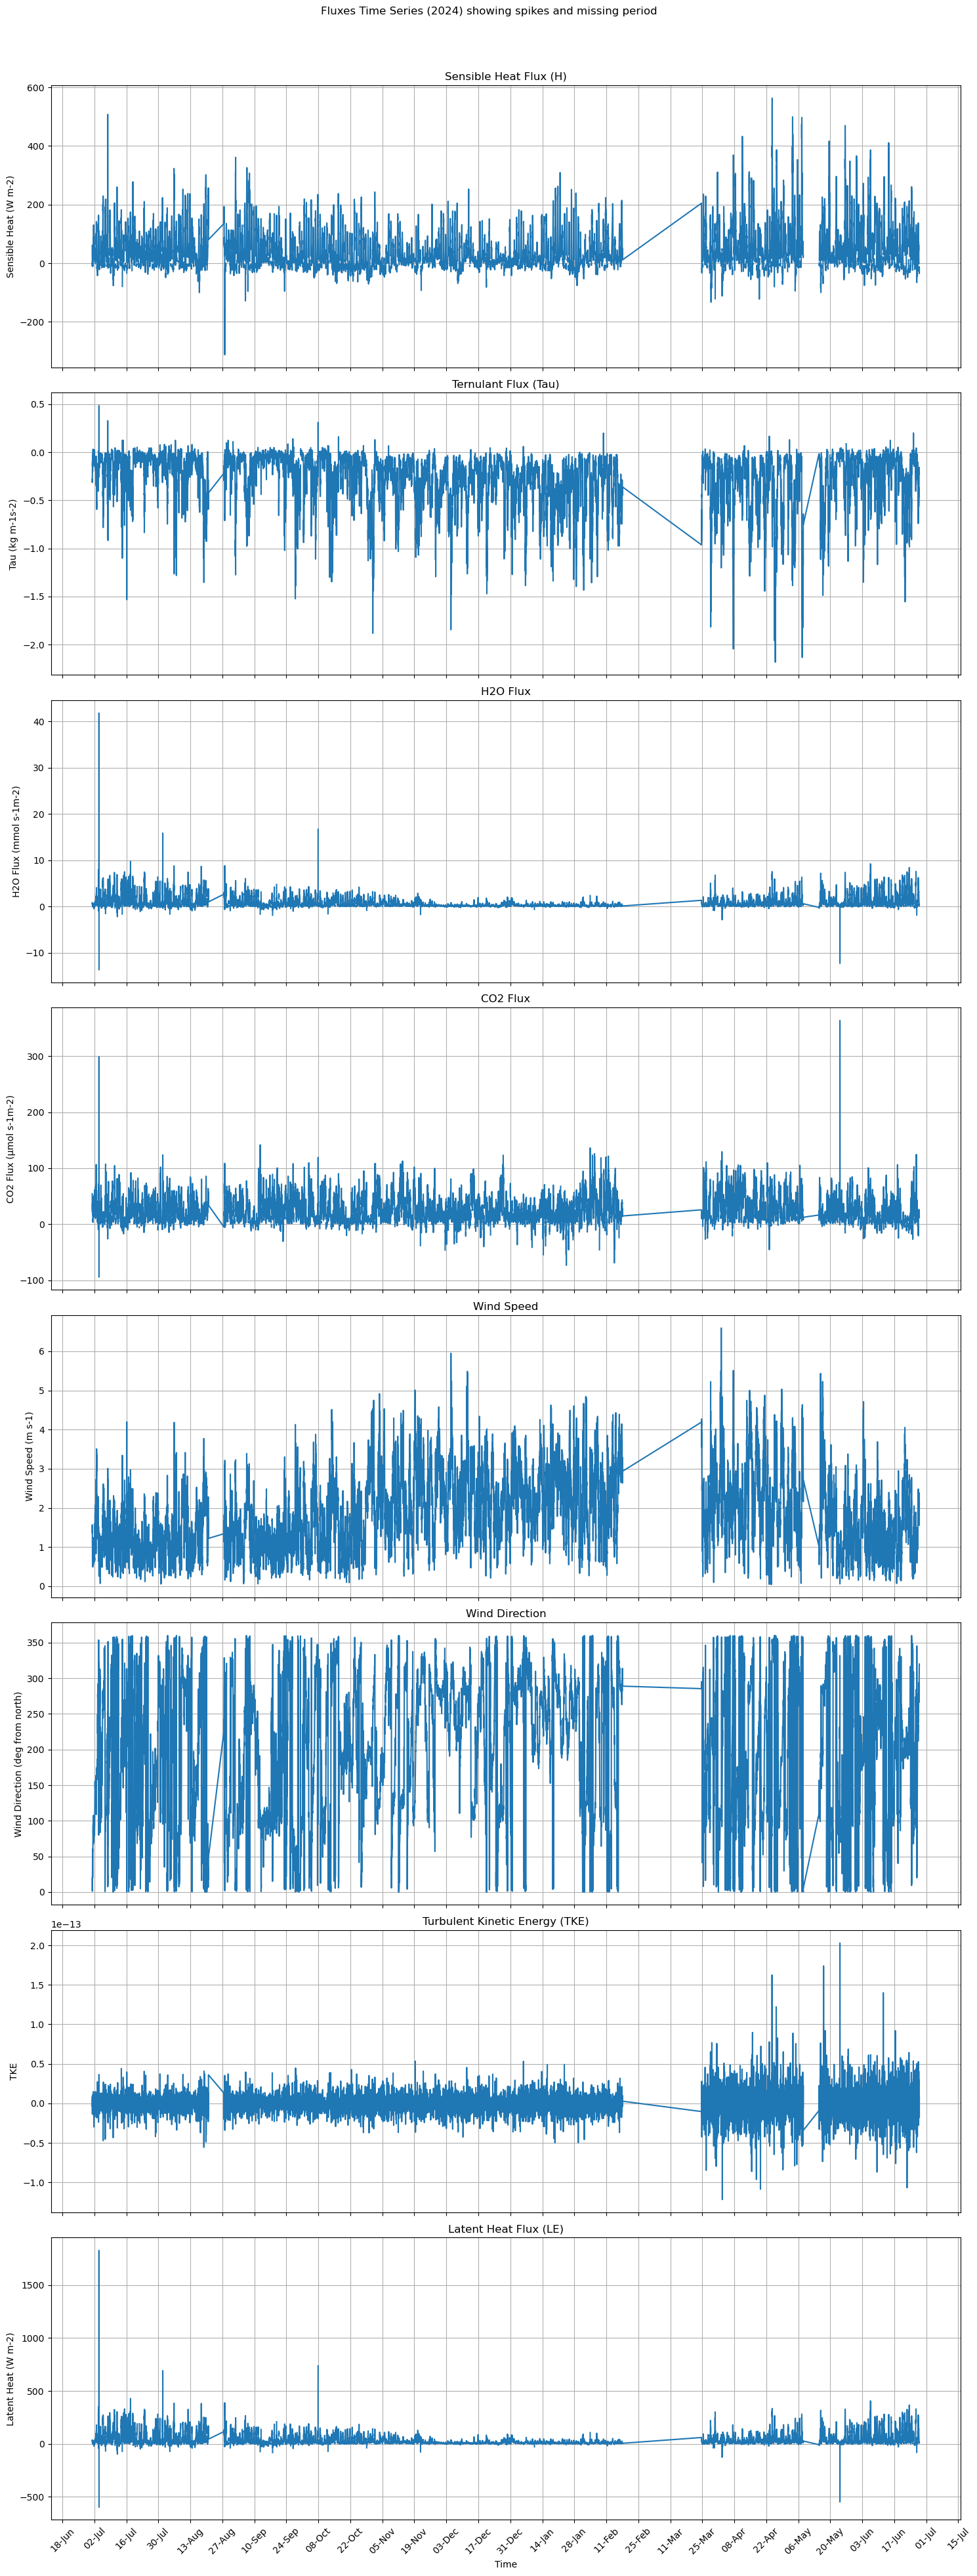

In [7]:
fig, axes = plt.subplots(nrows=8, ncols=1, figsize=(15, 40), sharex=True)

axes[0].plot(df['time'], df['H'])
axes[0].set_title('Sensible Heat Flux (H)')
axes[0].set_ylabel(f'Sensible Heat ({units["H"]})')

axes[1].plot(df['time'], df['Tau'])
axes[1].set_title('Ternulant Flux (Tau)')
axes[1].set_ylabel(f'Tau ({units["Tau"]})')

axes[2].plot(df['time'], df['H2O_flux'])
axes[2].set_title('H2O Flux')
axes[2].set_ylabel(f'H2O Flux ({units["H2O_flux"]})')

axes[3].plot(df['time'], df['CO2_flux'])
axes[3].set_title('CO2 Flux')
axes[3].set_ylabel(f'CO2 Flux ({units["CO2_flux"]})')

axes[4].plot(df['time'], df['wind_speed'])
axes[4].set_title('Wind Speed')
axes[4].set_ylabel(f'Wind Speed ({units["wind_speed"]})')

axes[5].plot(df['time'], df['wind_dir'])
axes[5].set_title('Wind Direction')
axes[5].set_ylabel(f'Wind Direction ({units["wind_dir"]})')

axes[6].plot(df['time'], df['w_rot'])
axes[6].set_title('Turbulent Kinetic Energy (TKE)')
axes[6].set_ylabel('TKE')

axes[7].plot(df['time'], df['LE'])
axes[7].set_title('Latent Heat Flux (LE)')
axes[7].set_ylabel(f'Latent Heat ({units["LE"]})')
axes[7].set_xlabel('Time')

for ax in axes:
    ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%d-%b'))
    ax.xaxis.set_major_locator(plt.matplotlib.dates.DayLocator(interval=14))
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True)

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.suptitle('Fluxes Time Series (2024) showing spikes and missing period')
plt.show()

### Cumulative Flux Analysis

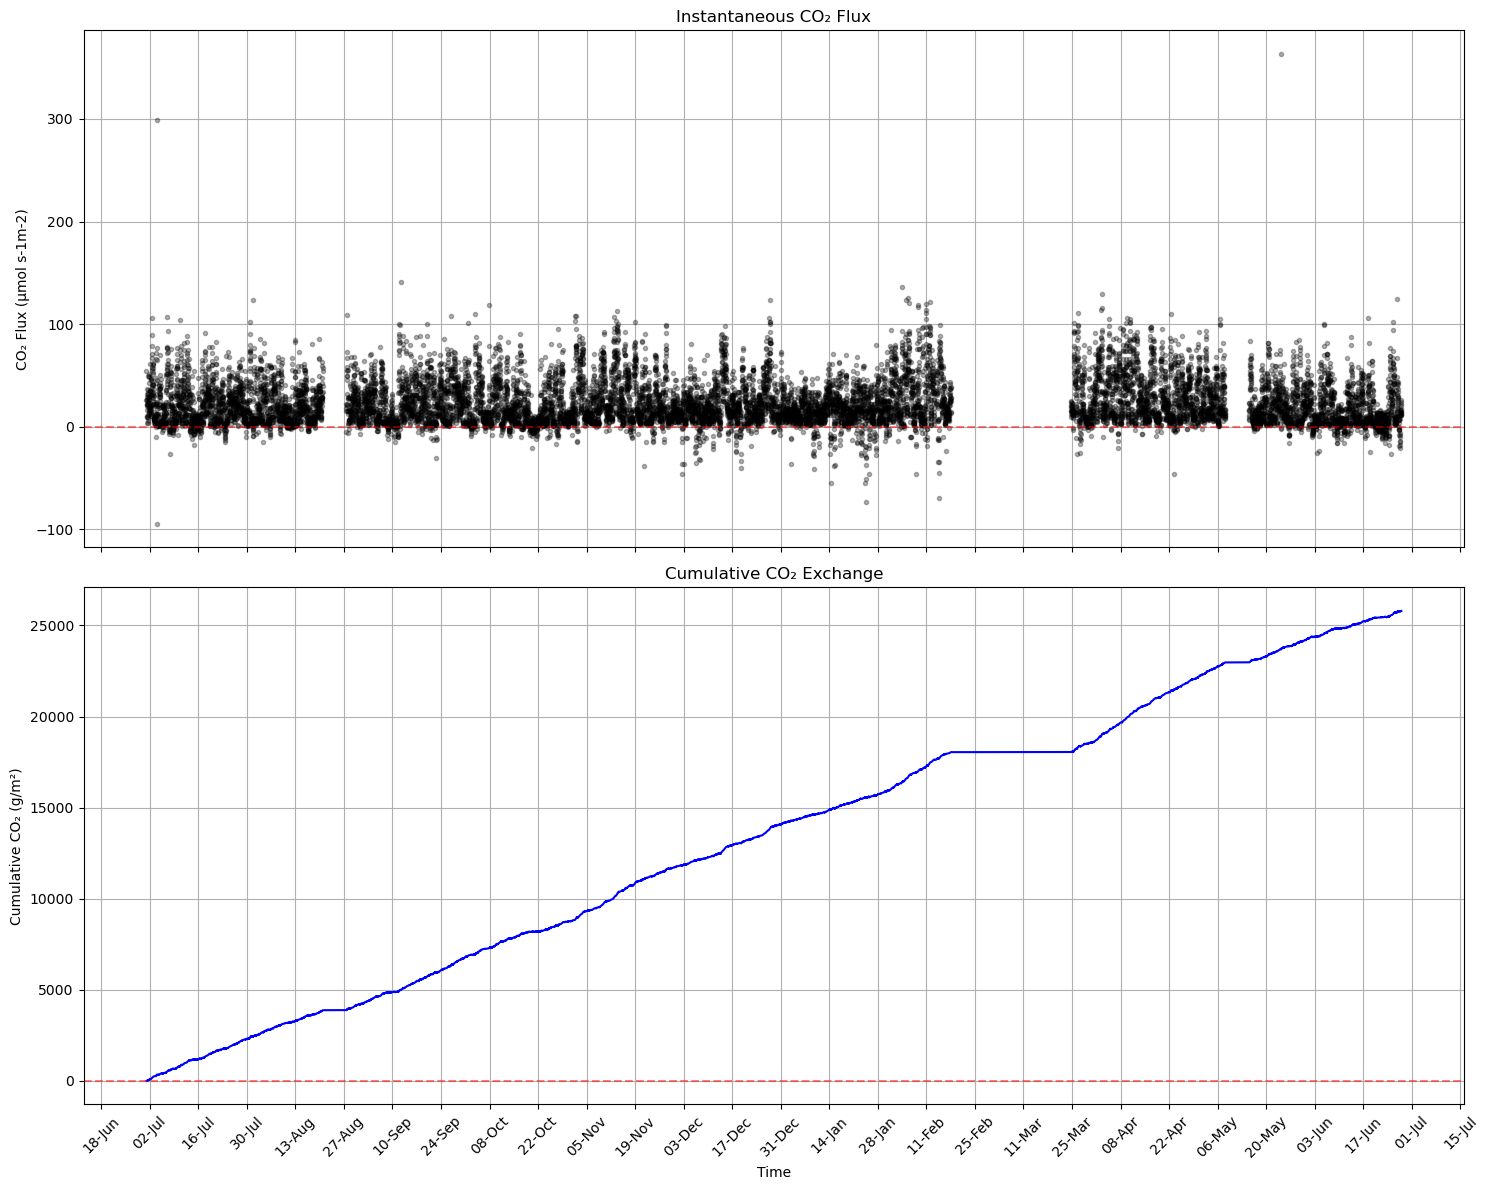

Total cumulative CO₂ flux: 25791.15 g/m²
Average daily CO₂ flux: 81.10 g/m²/day
Number of days with net emission: 318
Number of days with net uptake: 0


In [8]:
# Calculate cumulative fluxes (convert to g/m2 for CO2)
# Assuming 30-min averaged fluxes and converting from µmol/m²/s to g/m²
time_interval = 30 * 60  # seconds in 30 minutes
molar_mass_co2 = 44.01  # g/mol

# Calculate cumulative sum, converting units
df['CO2_flux_cumsum'] = (df['CO2_flux'] * time_interval * molar_mass_co2 / 1e6).cumsum()

# Create figure
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), sharex=True)

# Plot instantaneous CO2 flux
ax1.plot(df['time'], df['CO2_flux'], 'k.', alpha=0.3, label='30-min flux')
ax1.axhline(y=0, color='r', linestyle='--', alpha=0.5)
ax1.set_ylabel(f'CO₂ Flux ({units["CO2_flux"]})')
ax1.set_title('Instantaneous CO₂ Flux')
ax1.grid(True)

# Plot cumulative CO2 flux
ax2.plot(df['time'], df['CO2_flux_cumsum'], 'b-', label='Cumulative flux')
ax2.axhline(y=0, color='r', linestyle='--', alpha=0.5)
ax2.set_ylabel('Cumulative CO₂ (g/m²)')
ax2.set_xlabel('Time')
ax2.set_title('Cumulative CO₂ Exchange')
ax2.grid(True)

# Format x-axis
for ax in [ax1, ax2]:
    ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%d-%b'))
    ax.xaxis.set_major_locator(plt.matplotlib.dates.DayLocator(interval=14))
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# %% [markdown]
### Summary Statistics
# %%
# Calculate daily sums
daily_sums = df.groupby(df['time'].dt.date)['CO2_flux'].sum() * time_interval * molar_mass_co2 / 1e6

print(f"Total cumulative CO₂ flux: {df['CO2_flux_cumsum'].iloc[-1]:.2f} g/m²")
print(f"Average daily CO₂ flux: {daily_sums.mean():.2f} g/m²/day")
print(f"Number of days with net emission: {(daily_sums > 0).sum()}")
print(f"Number of days with net uptake: {(daily_sums < 0).sum()}")

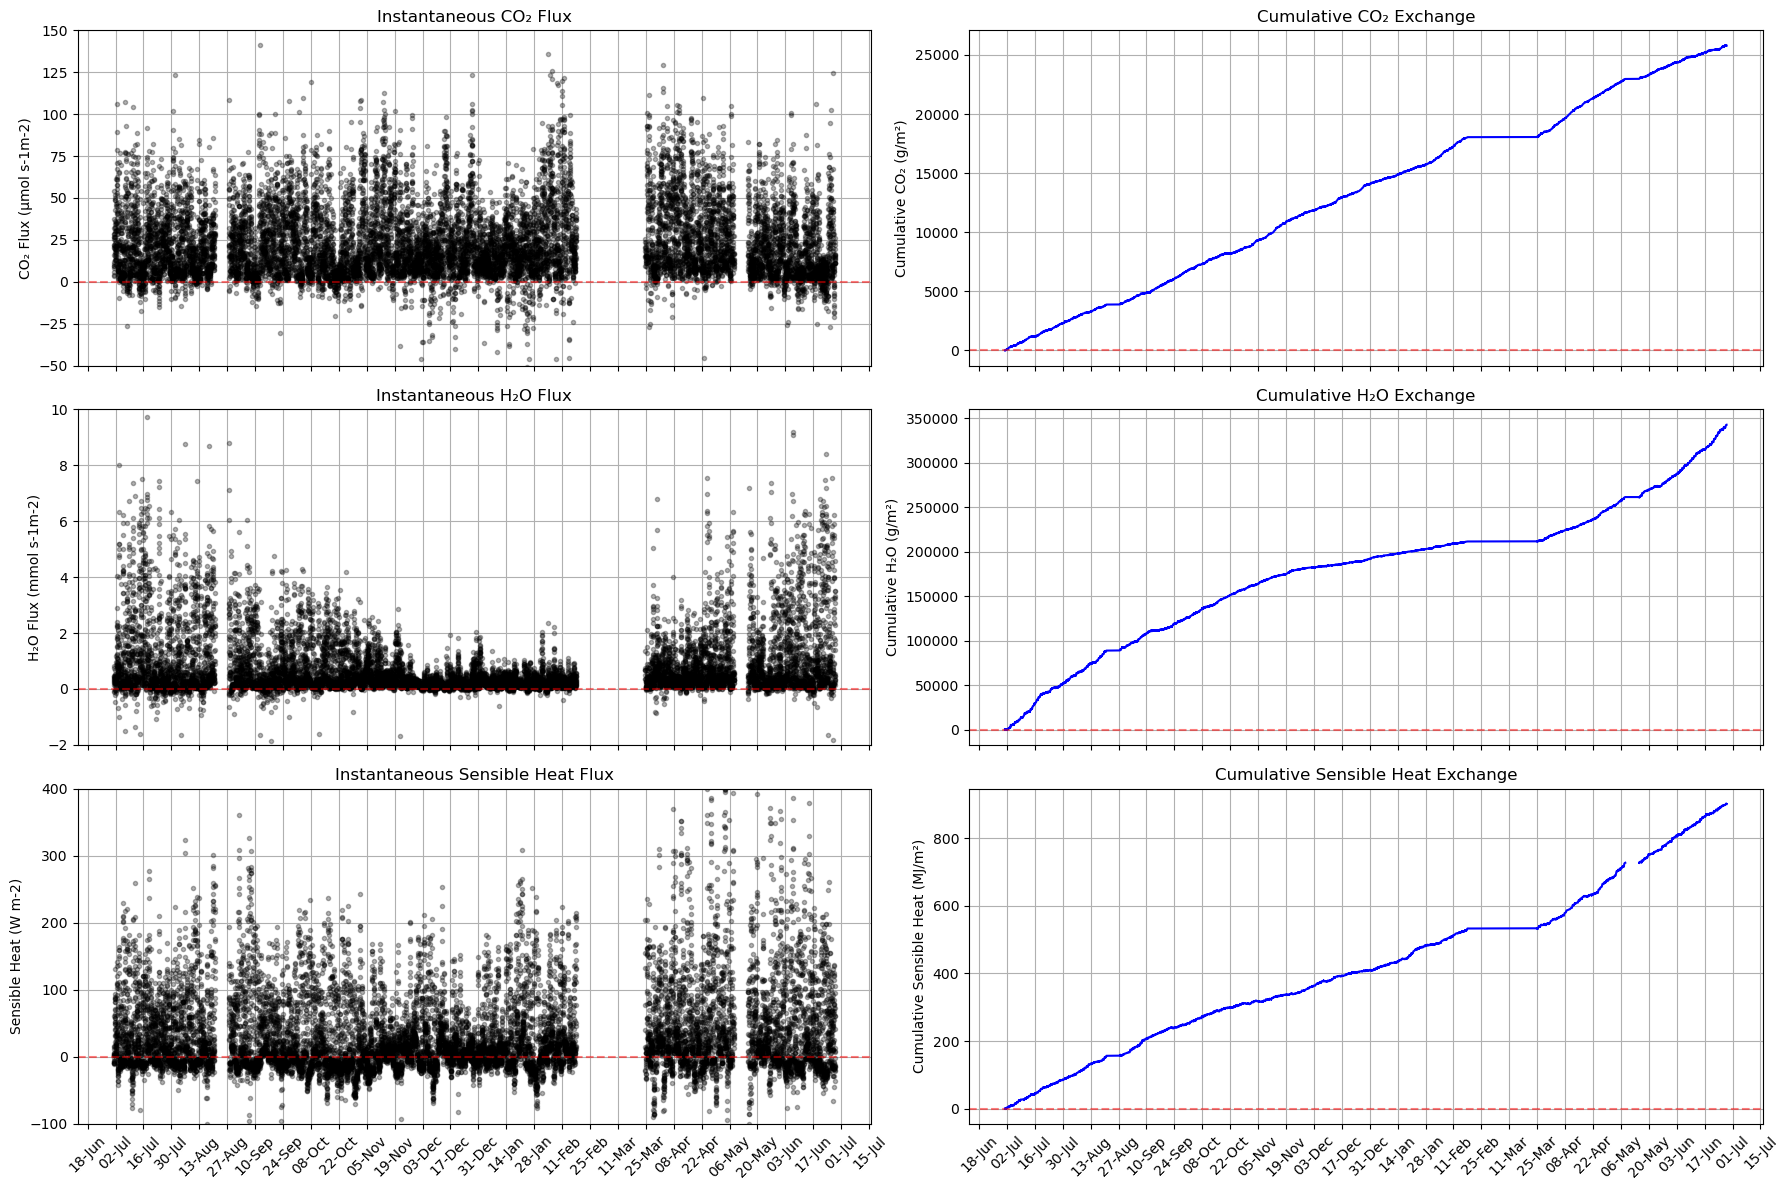


=== CO2 Flux Statistics ===
Total cumulative flux: 25791.15 g/m²
Average daily flux: 81.10 g/m²/day
Days with net emission: 318
Days with net uptake: 0

=== H2O Flux Statistics ===
Total cumulative flux: 342504.56 g/m²
Average daily flux: 1077.06 g/m²/day
Days with net emission: 316
Days with net uptake: 2

=== H Flux Statistics ===
Total cumulative flux: 900.95 g/m²
Average daily flux: 2.83 g/m²/day
Days with net emission: 299
Days with net uptake: 19


In [9]:
# %% [markdown]
### Cumulative Flux Analysis for CO2, H2O and Sensible Heat

# %%
# Calculate cumulative fluxes with appropriate unit conversions
time_interval = 30 * 60  # seconds in 30 minutes
molar_mass_co2 = 44.01  # g/mol
molar_mass_h2o = 18.02  # g/mol

# Calculate cumulative sums
df['CO2_flux_cumsum'] = (df['CO2_flux'] * time_interval * molar_mass_co2 / 1e6).cumsum()
df['H2O_flux_cumsum'] = (df['H2O_flux'] * time_interval * molar_mass_h2o / 1e3).cumsum()  # mmol to g
df['H_cumsum'] = (df['H'] * time_interval).cumsum() / 1e6  # W/m2 to MJ/m2

# Create figure
fig, axes = plt.subplots(3, 2, figsize=(18, 12), sharex=True)

# Plot CO2 fluxes
axes[0,0].plot(df['time'], df['CO2_flux'], 'k.', alpha=0.3)
axes[0,0].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[0,0].set_ylabel(f'CO₂ Flux ({units["CO2_flux"]})')
axes[0,0].set_title('Instantaneous CO₂ Flux')
axes[0,0].set_ylim(-50, 150)
axes[0,0].grid(True)

axes[0,1].plot(df['time'], df['CO2_flux_cumsum'], 'b-')
axes[0,1].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[0,1].set_ylabel('Cumulative CO₂ (g/m²)')
axes[0,1].set_title('Cumulative CO₂ Exchange')
axes[0,1].grid(True)

# Plot H2O fluxes
axes[1,0].plot(df['time'], df['H2O_flux'], 'k.', alpha=0.3)
axes[1,0].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[1,0].set_ylabel(f'H₂O Flux ({units["H2O_flux"]})')
axes[1,0].set_title('Instantaneous H₂O Flux')
axes[1, 0].set_ylim(-2, 10)
axes[1,0].grid(True)

axes[1,1].plot(df['time'], df['H2O_flux_cumsum'], 'b-')
axes[1,1].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[1,1].set_ylabel('Cumulative H₂O (g/m²)')
axes[1,1].set_title('Cumulative H₂O Exchange')
axes[1,1].grid(True)

# Plot Sensible Heat fluxes
axes[2,0].plot(df['time'], df['H'], 'k.', alpha=0.3)
axes[2,0].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[2,0].set_ylabel(f'Sensible Heat ({units["H"]})')
axes[2,0].set_title('Instantaneous Sensible Heat Flux')
axes[2,0].set_ylim(-100, 400)
axes[2,0].grid(True)

axes[2,1].plot(df['time'], df['H_cumsum'], 'b-')
axes[2,1].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[2,1].set_ylabel('Cumulative Sensible Heat (MJ/m²)')
axes[2,1].set_title('Cumulative Sensible Heat Exchange')
axes[2,1].grid(True)

# Format x-axis
for ax_row in axes:
    for ax in ax_row:
        ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%d-%b'))
        ax.xaxis.set_major_locator(plt.matplotlib.dates.DayLocator(interval=14))
        ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# %% [markdown]
### Summary Statistics

# %%
# Calculate daily sums
daily_stats = pd.DataFrame({
    'CO2': df.groupby(df['time'].dt.date)['CO2_flux'].sum() * time_interval * molar_mass_co2 / 1e6,
    'H2O': df.groupby(df['time'].dt.date)['H2O_flux'].sum() * time_interval * molar_mass_h2o / 1e3,
    'H': df.groupby(df['time'].dt.date)['H'].sum() * time_interval / 1e6
})

for flux_type in ['CO2', 'H2O', 'H']:
    print(f"\n=== {flux_type} Flux Statistics ===")
    print(f"Total cumulative flux: {daily_stats[flux_type].sum():.2f} g/m²")
    print(f"Average daily flux: {daily_stats[flux_type].mean():.2f} g/m²/day")
    print(f"Days with net emission: {(daily_stats[flux_type] > 0).sum()}")
    print(f"Days with net uptake: {(daily_stats[flux_type] < 0).sum()}")

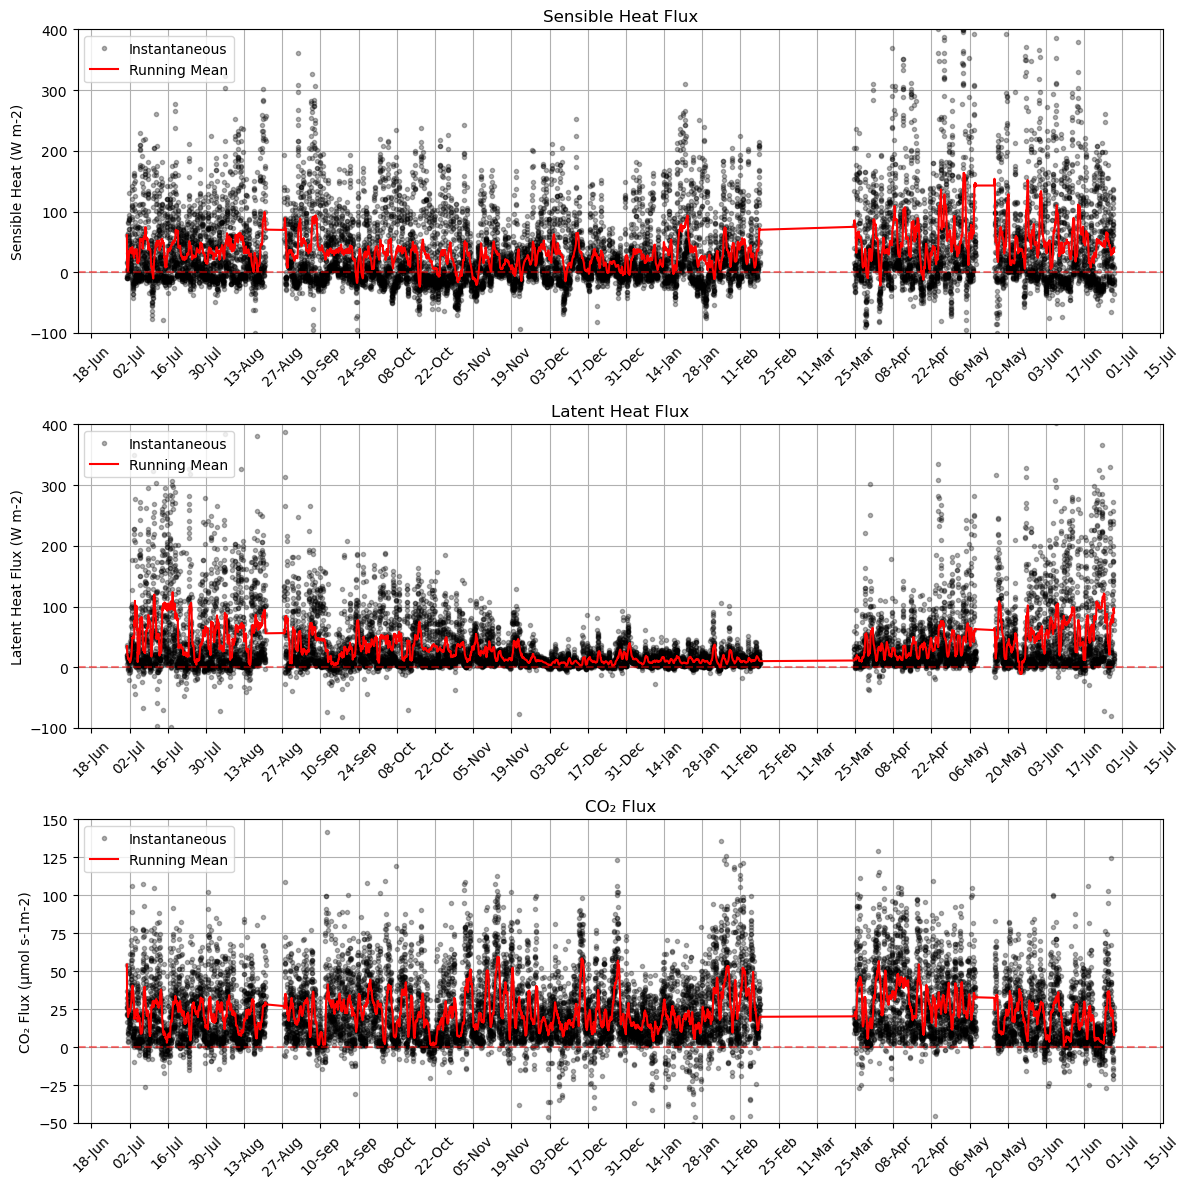

In [10]:
# Setup calculations
time_interval = 30 * 60  
molar_mass_co2 = 44.01

# Calculate running mean (using a window of 48, which corresponds to 24 hours for 30-min intervals)
window_size = 48
df['H_running_mean'] = df['H'].rolling(window=window_size, min_periods=1).mean()
df['LE_running_mean'] = df['LE'].rolling(window=window_size, min_periods=1).mean()
df['CO2_flux_running_mean'] = df['CO2_flux'].rolling(window=window_size, min_periods=1).mean()

# Create figure
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12))

# Plot Sensible Heat fluxes
ax1.plot(df['time'], df['H'], 'k.', alpha=0.3, label='Instantaneous')
ax1.plot(df['time'], df['H_running_mean'], 'r-', label='Running Mean')
ax1.axhline(y=0, color='r', linestyle='--', alpha=0.5)
ax1.set_ylabel(f'Sensible Heat ({units["H"]})')
ax1.set_title('Sensible Heat Flux')
ax1.set_ylim(-100, 400)

# Plot Latent Heat fluxes
ax2.plot(df['time'], df['LE'], 'k.', alpha=0.3, label='Instantaneous')
ax2.plot(df['time'], df['LE_running_mean'], 'r-', label='Running Mean')
ax2.axhline(y=0, color='r', linestyle='--', alpha=0.5)
ax2.set_ylabel(f'Latent Heat Flux ({units["LE"]})')
ax2.set_title('Latent Heat Flux')
ax2.set_ylim(-100, 400)

# Plot CO2 fluxes
ax3.plot(df['time'], df['CO2_flux'], 'k.', alpha=0.3, label='Instantaneous')
ax3.plot(df['time'], df['CO2_flux_running_mean'], 'r-', label='Running Mean')
ax3.axhline(y=0, color='r', linestyle='--', alpha=0.5)
ax3.set_ylabel(f'CO₂ Flux ({units["CO2_flux"]})')
ax3.set_title('CO₂ Flux')
ax3.set_ylim(-50, 150)

# Format axes and add legends
for ax in [ax1, ax2, ax3]:
    ax.grid(True)
    ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%d-%b'))
    ax.xaxis.set_major_locator(plt.matplotlib.dates.DayLocator(interval=14))
    ax.tick_params(axis='x', rotation=45)
    ax.legend(loc='upper left')

plt.tight_layout()
plt.savefig('/Users/bhupendra/projects/crocus/plots/flux_analysis/fluxes_with_running_mean-2024.pdf', dpi=300, bbox_inches='tight')
plt.show()


In [11]:
# %% [markdown]
### Statistical Analysis with Outlier Removal

# %%
import scipy.stats as stats
import seaborn as sns
import numpy as np

# Function to remove outliers using IQR method
def remove_outliers(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data >= lower_bound) & (data <= upper_bound)]

# Create clean dataframe without outliers
df_clean = df.copy()
for var in flux_vars:
    df_clean[var] = remove_outliers(df[var])

# Create figure for violin plots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# Statistical results storage
stats_results = {}

for idx, var in enumerate(flux_vars):
    # Prepare data
    weekday_data = df_clean[~df_clean['is_weekend']][var].dropna()
    weekend_data = df_clean[df_clean['is_weekend']][var].dropna()
    
    # Create violin plot
    sns.violinplot(data=df_clean, x='is_weekend', y=var, ax=axes[idx])
    axes[idx].set_xlabel('Weekend' if idx >= 3 else '')
    axes[idx].set_xticklabels(['Weekday', 'Weekend'])
    axes[idx].set_title(f'{var} Distribution (Outliers Removed)')
    axes[idx].set_ylabel(f'{var} ({units.get(var, "")})')
    
    # Perform both tests
    # Mann-Whitney U test
    mw_stat, mw_pvalue = stats.mannwhitneyu(weekday_data, weekend_data, alternative='two-sided')
    
    # T-test
    t_stat, t_pvalue = stats.ttest_ind(weekday_data, weekend_data)
    
    stats_results[var] = {
        'mw_stat': mw_stat, 
        'mw_pvalue': mw_pvalue,
        't_stat': t_stat, 
        't_pvalue': t_pvalue
    }
    
    # Add p-value annotations
    axes[idx].text(0.5, 0.95, f'MW p = {mw_pvalue:.3f}\nt p = {t_pvalue:.3f}', 
                  horizontalalignment='center',
                  transform=axes[idx].transAxes)

# Remove extra subplot
if len(axes) > len(flux_vars):
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

# %% [markdown]
### Statistical Test Results After Outlier Removal

# %%
print("Statistical Test Results (Outliers Removed):")
print("H0: Weekday and weekend distributions are the same")
print("H1: Distributions are different\n")

for var in flux_vars:
    print(f"\n=== {var} ===")
    print("Mann-Whitney U Test:")
    print(f"Statistic: {stats_results[var]['mw_stat']:.2f}")
    print(f"P-value: {stats_results[var]['mw_pvalue']:.4f}")
    print(f"Conclusion: {'Reject H0' if stats_results[var]['mw_pvalue'] < 0.05 else 'Fail to reject H0'}")
    
    print("\nStudent's t-test:")
    print(f"Statistic: {stats_results[var]['t_stat']:.2f}")
    print(f"P-value: {stats_results[var]['t_pvalue']:.4f}")
    print(f"Conclusion: {'Reject H0' if stats_results[var]['t_pvalue'] < 0.05 else 'Fail to reject H0'}")

# %% [markdown]
### Summary Statistics by Day Type (Outliers Removed)

# %%
summary_stats_clean = pd.DataFrame({
    'Weekday': df_clean[~df_clean['is_weekend']][flux_vars].mean(),
    'Weekend': df_clean[df_clean['is_weekend']][flux_vars].mean(),
    'Weekday_std': df_clean[~df_clean['is_weekend']][flux_vars].std(),
    'Weekend_std': df_clean[df_clean['is_weekend']][flux_vars].std()
})

print("\nMean and Standard Deviation by Day Type (Outliers Removed):")
print(summary_stats_clean)

# Print percentage of data removed as outliers
print("\nPercentage of data points removed as outliers:")
for var in flux_vars:
    original_count = df[var].count()
    clean_count = df_clean[var].count()
    removed_pct = (original_count - clean_count) / original_count * 100
    print(f"{var}: {removed_pct:.1f}%")

NameError: name 'flux_vars' is not defined

In [ ]:
# %% [markdown]
### Detailed Statistical Analysis of CO2 Flux Weekday vs Weekend Differences

# %%
import scipy.stats as stats
import seaborn as sns
import numpy as np
from scipy import stats

def cohens_d(group1, group2):
    """Calculate Cohen's d effect size"""
    n1, n2 = len(group1), len(group2)
    var1, var2 = np.var(group1, ddof=1), np.var(group2, ddof=1)
    
    # Pooled standard deviation
    pooled_se = np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2))
    
    return (np.mean(group1) - np.mean(group2)) / pooled_se

# Prepare data
weekday_co2 = df_clean[~df_clean['is_weekend']]['CO2_flux'].dropna()
weekend_co2 = df_clean[df_clean['is_weekend']]['CO2_flux'].dropna()

# Calculate effect size
effect_size = cohens_d(weekday_co2, weekend_co2)

# Create figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Distribution plot
sns.kdeplot(data=weekday_co2, label='Weekday', ax=ax1)
sns.kdeplot(data=weekend_co2, label='Weekend', ax=ax1)
ax1.set_title('CO2 Flux Distribution')
ax1.set_xlabel(f'CO2 Flux ({units["CO2_flux"]})')
ax1.legend()

# Box plot with sample size annotations
sns.boxplot(data=df_clean, x='is_weekend', y='CO2_flux', ax=ax2)
ax2.set_xticklabels([f'Weekday\n(n={len(weekday_co2)})', 
                     f'Weekend\n(n={len(weekend_co2)})'])
ax2.set_title('CO2 Flux Box Plot')

# Add statistical information
stats_text = (
    f"Statistics:\n"
    f"Cohen's d: {effect_size:.3f}\n"
    f"t-stat: {stats_results['CO2_flux']['t_stat']:.3f}\n"
    f"p-value: {stats_results['CO2_flux']['t_pvalue']:.3e}\n"
    f"Weekday mean: {weekday_co2.mean():.2f}\n"
    f"Weekend mean: {weekend_co2.mean():.2f}\n"
    f"Weekday std: {weekday_co2.std():.2f}\n"
    f"Weekend std: {weekend_co2.std():.2f}"
)

plt.figtext(1.02, 0.5, stats_text, fontsize=10, va='center')

plt.tight_layout()
plt.show()

# Interpret effect size
def interpret_cohens_d(d):
    if abs(d) < 0.2: return "negligible"
    elif abs(d) < 0.5: return "small"
    elif abs(d) < 0.8: return "medium"
    else: return "large"

print(f"\nEffect size interpretation:")
print(f"Cohen's d = {effect_size:.3f} ({interpret_cohens_d(effect_size)} effect)")

KeyError: 'is_weekend'